# I/ setUpEnvironment

In [1]:
#to access files and folders
import os
#data analysis and manipulation library
import pandas as pd
#math operations for multi-dimensional arrays and matrices
import numpy as np
#visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
sns.set() #use a specific color theme

import warnings
warnings.simplefilter("ignore")#ignore warnings during execution

#Using model
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GroupKFold
from sklearn.feature_selection import RFECV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score,log_loss
from sklearn.metrics import confusion_matrix

from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC


# II/ readData

In [2]:
#read the data
data_folder_path = '/kaggle/input/cognitiveload/UBIcomp2020/last_30s_segments/'
#read the data
print('Reading data')
label_df = pd.read_excel(data_folder_path+'labels.xlsx',index_col=0)
temp_df= pd.read_excel(data_folder_path+'temp.xlsx',index_col=0)
hr_df= pd.read_excel(data_folder_path+'hr.xlsx',index_col=0)
gsr_df = pd.read_excel(data_folder_path+'gsr.xlsx',index_col=0)
rr_df= pd.read_excel(data_folder_path+'rr.xlsx',index_col=0)
print('Done')

#check 30-second segments
print("Data shapes:")
print('Labels',label_df.shape)
print('Temperature',temp_df.shape)
print('Heartrate',hr_df.shape)
print('GSR',gsr_df.shape)
print('RR',rr_df.shape)

Reading data
Done
Data shapes:
Labels (825, 21)
Temperature (825, 30)
Heartrate (825, 30)
GSR (825, 30)
RR (825, 30)


# III/ statisticalFeatures

**SMA**

In [3]:
window = 3
#apply moving average to each 30-second segment separately
temp_df = temp_df.rolling(window,axis=1).mean()
hr_df = hr_df.rolling(window,axis=1).mean()
gsr_df = gsr_df.rolling(window,axis=1).mean()
rr_df = rr_df.rolling(window,axis=1).mean()

In [4]:
def extract_stat_features(df,data_type=''):
  stat_features_names = ['mean','std','skew','kurtosis','diff','diff2','q25','q75','qdev','max-min']
  final_names =  [data_type + '_' + x for x in stat_features_names]
  features = pd.DataFrame(columns = stat_features_names) #create empty dataframe
  values = [df.mean(axis=1).values, #mean
            df.std(axis=1).values,  #standard deviation
            df.skew(axis=1).values, #skewness
            df.kurtosis(axis=1).values, #kurtosis
            df.diff(axis=1).mean(axis=1).values, #mean value of first derivative
            df.diff(axis=1).diff(axis=1).mean(axis=1).values, #mean value of second derivative
            df.quantile(0.25,axis=1).values, #25th quantile
            df.quantile(0.75,axis=1).values,#75th quantile
            df.quantile(0.75,axis=1).values-df.quantile(0.25,axis=1).values, #quartile deviation
            df.max(axis=1).values-df.min(axis=1).values] #range
  values  = np.column_stack(values)
  return pd.DataFrame(values,columns = final_names)

In [5]:
#extract features from heart-rate data
temp_stat_features = extract_stat_features(temp_df,'temp')

hr_stat_features = extract_stat_features(hr_df,'hr')

gsr_stat_features = extract_stat_features(gsr_df,'gsr')

rr_stat_features = extract_stat_features(rr_df,'rr')

#merge all statistical features into one table
stat_feat_all = pd.concat([temp_stat_features,hr_stat_features,gsr_stat_features,rr_stat_features],axis=1)
stat_feat_all

,temp_mean,temp_std,temp_skew,temp_kurtosis,temp_diff,temp_diff2,temp_q25,temp_q75,temp_qdev,temp_max-min,...,rr_mean,rr_std,rr_skew,rr_kurtosis,rr_diff,rr_diff2,rr_q25,rr_q75,rr_qdev,rr_max-min
0,34.467143,1.439289e-02,-0.304097,-1.970264,0.001111,0.000000,34.450001,34.480000,0.029999,0.029999,...,0.877500,0.027143,-0.763675,0.156772,0.000683,-0.001347,0.866702,0.893203,0.026501,0.114300
1,34.500000,7.235813e-15,0.000000,0.000000,0.000000,0.000000,34.500000,34.500000,0.000000,0.000000,...,0.706345,0.110785,-0.174618,-1.326351,-0.007511,0.004680,0.636948,0.804712,0.167764,0.342901
2,34.542858,8.486061e-03,3.201772,9.824660,0.001317,0.000342,34.540001,34.540001,0.000000,0.035556,...,0.903935,0.053947,-0.749310,0.150436,0.007647,-0.003403,0.882141,0.947588,0.065446,0.206478
3,34.620316,1.313223e-03,4.615168,22.128099,0.000247,0.000171,34.619999,34.619999,0.000000,0.006667,...,0.880495,0.061818,-0.244362,-0.228024,0.001024,0.001205,0.838818,0.919473,0.080656,0.252567
4,35.160000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,35.160000,35.160000,0.000000,0.000000,...,0.970434,0.019813,0.016184,-1.252647,0.001707,0.000496,0.956805,0.988607,0.031801,0.064524
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
820,34.158570,1.733603e-02,-0.997460,-0.957454,-0.001481,0.000000,34.141111,34.169998,0.028887,0.039997,...,0.829995,0.047219,-0.532316,0.388827,0.007169,0.001418,0.805634,0.859097,0.053463,0.200948
821,34.004286,1.851647e-02,0.627772,-1.632652,-0.001481,0.000000,33.990002,34.029999,0.039997,0.039997,...,0.898371,0.068842,-0.049318,-1.673079,0.002868,-0.002907,0.832826,0.965562,0.132736,0.196339
822,33.785715,1.891403e-02,0.462098,-1.834867,-0.001482,0.000000,33.770000,33.810001,0.040001,0.040001,...,0.869895,0.049726,0.631782,0.144345,0.001570,-0.000213,0.838818,0.890898,0.052080,0.199104
823,34.080200,1.049885e-03,5.291503,28.000000,-0.000206,0.000214,34.080002,34.080002,0.000000,0.005555,...,0.746278,0.121088,-1.325087,1.756621,0.001434,0.004254,0.733505,0.795033,0.061529,0.510665


In [7]:
test_ids = ['3caqi','6frz4','bd47a','f1gjp','iz3x1']

train_ids = ['1mpau', '2nxs5', '5gpsc', '7swyk', '8a1ep', 'b7mrd',
       'c24ur', 'dkhty', 'e4gay', 'ef5rq', 'f3j25', 'hpbxa',
       'ibvx8', 'iz2ps', 'rc1in', 'tn4vl', 'wjxci', 'yljm5']

X_train = []
y_train = []
X_test = []
y_test = []
user_train = []
user_test = []


for user in label_df.user_id.unique():
    if user in train_ids:
        user_features = stat_feat_all[label_df.user_id == user]
        X_train.append(user_features)
        y = label_df.loc[label_df.user_id == user, 'level'].values
        
        # Convert labels (rest,0,1,2) to binary (rest vs task)
        y[y == 'rest'] = -1
        y = y.astype(int) + 1
        y[y > 0] = 1
        y_train.extend(y)
        
        temp = label_df.loc[label_df.user_id==user,'user_id'].values #labels
        user_train.extend(temp)
    elif user in test_ids:
        user_features = stat_feat_all[label_df.user_id == user]
        X_test.append(user_features)
        y = label_df.loc[label_df.user_id == user, 'level'].values
        
        # Convert labels (rest,0,1,2) to binary (rest vs task)
        y[y == 'rest'] = -1
        y = y.astype(int) + 1
        y[y > 0] = 1
        y_test.extend(y)
        
        temp = label_df.loc[label_df.user_id==user,'user_id'].values #labels
        user_test.extend(temp)

# Concatenate and convert to DataFrame/NumPy array
X_train = pd.concat(X_train, ignore_index=True)
y_train = np.array(y_train)
X_test = pd.concat(X_test, ignore_index=True)
y_test = np.array(y_test)

print('Train data:', X_train.shape, y_train.shape)
print('Test data:', X_test.shape, y_test.shape)


Train data: (632, 40) (632,)
Test data: (193, 40) (193,)


# IV/ **Preprocessing**

In [8]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)

# **V/ featuresSelection**

In [14]:
from sklearn.neighbors import KNeighborsClassifier
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
# selected feature
model = SVC(kernel='linear')  # 'linear', 'poly', 'rbf', 'sigmoid', 'precomputed'

sbs = SFS(model, 
          k_features=11, 
          forward=False, 
          floating=True, 
          scoring='accuracy',
          cv=4,
          n_jobs=-1)
sbs = sbs.fit(X_train, y_train)

fs_train_orig = pd.DataFrame()
fs_test_orig = pd.DataFrame()
columns = X_train.columns

# Thay đổi cách nối cột và tên cột
for i in sbs.k_feature_idx_:
    # Thêm cột vào fs_train và fs_test với tên cột tương ứng
    fs_train_orig[columns[i]] = X_train[columns[i]]
    fs_test_orig[columns[i]] = X_test[columns[i]]
X_train = fs_train_orig
X_test = fs_test_orig

In [11]:
# from mlxtend.feature_selection import SequentialFeatureSelector as SFS
# from sklearn.svm import SVC
# import matplotlib.pyplot as plt
# import numpy as np

# # Khởi tạo mô hình
# model = SVC(kernel='linear')

# # Duyệt qua các giá trị k từ 5 đến 40
# k_features_range = list(range(5, 41))  # Chọn số lượng đặc trưng từ 5 đến 40
# scores = []

# # Thực hiện lựa chọn đặc trưng với từng giá trị k_features
# for k in k_features_range:
#     sfs = SFS(model, 
#               k_features=k, 
#               forward=True, 
#               floating=True, 
#               scoring='accuracy',
#               cv=4,
#               n_jobs=-1)
#     sfs = sfs.fit(X_train, y_train)
#     scores.append(sfs.k_score_)

# # Vẽ biểu đồ hiệu suất so với số lượng đặc trưng
# plt.plot(k_features_range, scores, marker='o')
# plt.xlabel('Number of Features')
# plt.ylabel('Cross-Validation Accuracy')
# plt.title('Selecting the optimal number of features')
# plt.grid()
# plt.show()

# # Tìm số lượng đặc trưng với điểm số cao nhất
# optimal_k = k_features_range[np.argmax(scores)]
# print(f'Số lượng đặc trưng tốt nhất: {optimal_k} với độ chính xác: {max(scores):.4f}')


In [17]:
# Get the selected feature indices and names
selected_features_idx = sbs.k_feature_idx_
selected_features_names = [columns[i] for i in selected_features_idx]

# Print the selected features
print("Selected features:", selected_features_names)


Selected features: [0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 13, 16, 17, 18, 20, 22, 23, 26, 27, 28, 31, 32, 33, 36, 38, 39]


# **VI/ Experiment**

# **Logistic Regession**

User of train_fold(0) : ['1mpau' '2nxs5' '7swyk' '8a1ep' 'b7mrd' 'c24ur' 'e4gay' 'ef5rq' 'f3j25'
 'ibvx8' 'iz2ps' 'rc1in' 'tn4vl' 'wjxci' 'yljm5']
User of val_fold(0) :['5gpsc' 'dkhty' 'hpbxa']
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best parameters found: {'C': 0.01, 'penalty': 'l2', 'solver': 'liblinear'}

User of train_fold(1) : ['1mpau' '2nxs5' '5gpsc' '7swyk' '8a1ep' 'b7mrd' 'c24ur' 'dkhty' 'e4gay'
 'ef5rq' 'f3j25' 'hpbxa' 'ibvx8' 'iz2ps' 'wjxci']
User of val_fold(1) :['rc1in' 'tn4vl' 'yljm5']
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best parameters found: {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}

User of train_fold(2) : ['1mpau' '2nxs5' '5gpsc' '7swyk' '8a1ep' 'b7mrd' 'dkhty' 'e4gay' 'f3j25'
 'hpbxa' 'iz2ps' 'rc1in' 'tn4vl' 'wjxci' 'yljm5']
User of val_fold(2) :['c24ur' 'ef5rq' 'ibvx8']
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best parameters found: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}

User of t

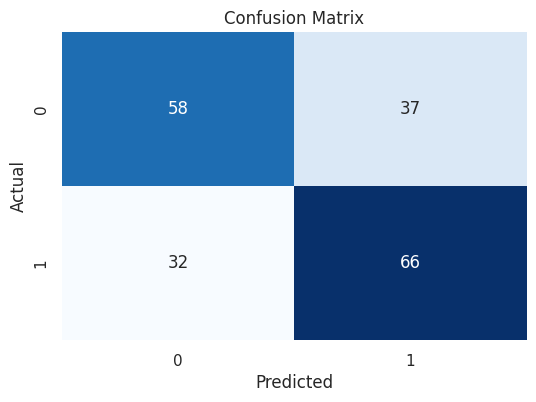

Accucracy all fold: [0.56521739 0.64285714 0.65178571 0.61111111 0.67708333 0.64285714]
Mean: 0.6318186392914654 ---- Std: 0.035486621162654455
LogLoss all fold: [0.66404178 0.6604247  0.62813458 0.67320911 0.61049352 0.66455628]
Mean: 0.650143326978466 ---- Std: 0.02271243921035226


In [19]:
kf = GroupKFold(n_splits=6)

best_model = None
best_score = 0
fold_results = []
accuracy_all = []
logloss_all = []

# Lặp qua từng fold
for fold, (train_index, val_index) in enumerate(kf.split(X_train, y_train, groups = user_train)):
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
    
    id_user = np.array(user_train)
    # Kiểm tra nhóm trong fold
    train_groups = id_user[train_index]
    val_groups = id_user[val_index]
    
    print(f'User of train_fold({fold}) : {np.unique(train_groups)}')
    print(f'User of val_fold({fold}) :{np.unique(val_groups)}')    

    logreg = LogisticRegression()
    # Find best parmeter 
    param_grid = {
        'C': [0.01, 0.1, 1, 10, 100],
        'penalty': ['l1', 'l2'],        
        'solver': ['liblinear']         
    }
    grid_search = GridSearchCV(estimator=logreg, param_grid=param_grid, cv=GroupKFold(n_splits=3), scoring='accuracy', verbose=1)
    grid_search.fit(X_train_fold, y_train_fold, groups = train_groups)
    print(f"Best parameters found: {grid_search.best_params_}\n" )
    
    y_val_pred = grid_search.predict(X_val_fold)
    y_pred_prob = grid_search.predict_proba(X_val_fold)

    accuracy = accuracy_score(y_val_fold, y_val_pred)
    conf_matrix = confusion_matrix(y_val_fold, y_val_pred)
    class_report = classification_report(y_val_fold, y_val_pred)
    logloss = log_loss(y_val_fold, y_pred_prob)

    fold_results.append({
        "fold": fold,
        "model": logreg,
        "accuracy": accuracy,
        "confusion_matrix": conf_matrix,
        "classification_report": class_report
        })
    accuracy_all.append(accuracy)
    logloss_all.append(logloss)

    if accuracy > best_score:
        best_score = accuracy
        best_model = grid_search

# Dự đoán trên tập kiểm tra
y_pred_lr = best_model.predict(X_test)
y_pred_lr_proba = best_model.predict_proba(X_test)

# Đánh giá mô hình trên tập kiểm tra
lr = accuracy_score(y_test, y_pred_lr)
conf_matrix = confusion_matrix(y_test, y_pred_lr)
class_report = classification_report(y_test, y_pred_lr)
lr_logloss = log_loss(y_test, y_pred_lr_proba)

print("Report:" + class_report)
print(f"ACCURACY: {lr}")
print(f"LOGLOSS: {lr_logloss}")


# Xác định các lớp để hiển thị trong ma trận nhầm lẫn
unique_labels = np.unique(np.concatenate((y_test, y_pred_lr)))

plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=unique_labels.tolist(), 
            yticklabels=unique_labels.tolist())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

accuracy_all = np.array(accuracy_all)
logloss_all = np.array(logloss_all)
print(f"Accucracy all fold: {accuracy_all}\nMean: {accuracy_all.mean()} ---- Std: {accuracy_all.std()}")
print(f"LogLoss all fold: {logloss_all}\nMean: {logloss_all.mean()} ---- Std: {logloss_all.std()}")


# **LDA**

User of train_fold(0) : ['1mpau' '2nxs5' '7swyk' '8a1ep' 'b7mrd' 'c24ur' 'e4gay' 'ef5rq' 'f3j25'
 'ibvx8' 'iz2ps' 'rc1in' 'tn4vl' 'wjxci' 'yljm5']
User of val_fold(0) :['5gpsc' 'dkhty' 'hpbxa']
Fitting 3 folds for each of 15 candidates, totalling 45 fits
Best parameters found: {'shrinkage': 0.9, 'solver': 'lsqr'}

User of train_fold(1) : ['1mpau' '2nxs5' '5gpsc' '7swyk' '8a1ep' 'b7mrd' 'c24ur' 'dkhty' 'e4gay'
 'ef5rq' 'f3j25' 'hpbxa' 'ibvx8' 'iz2ps' 'wjxci']
User of val_fold(1) :['rc1in' 'tn4vl' 'yljm5']
Fitting 3 folds for each of 15 candidates, totalling 45 fits
Best parameters found: {'shrinkage': 0.5, 'solver': 'lsqr'}

User of train_fold(2) : ['1mpau' '2nxs5' '5gpsc' '7swyk' '8a1ep' 'b7mrd' 'dkhty' 'e4gay' 'f3j25'
 'hpbxa' 'iz2ps' 'rc1in' 'tn4vl' 'wjxci' 'yljm5']
User of val_fold(2) :['c24ur' 'ef5rq' 'ibvx8']
Fitting 3 folds for each of 15 candidates, totalling 45 fits
Best parameters found: {'shrinkage': 0.1, 'solver': 'lsqr'}

User of train_fold(3) : ['1mpau' '2nxs5' '5gpsc' '7s

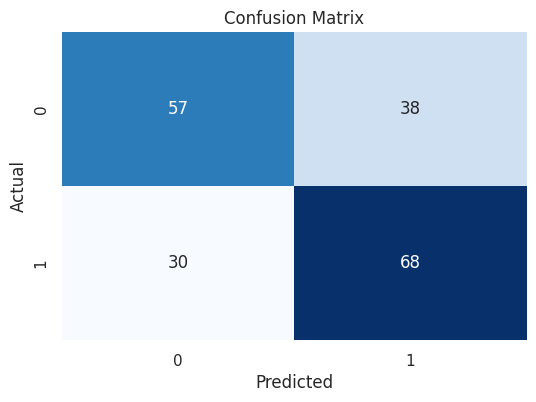

Accucracy All : [0.58695652 0.65178571 0.67857143 0.59259259 0.69791667 0.61607143]
Mean: 0.6373157254044934 ---- Std: 0.041975024030436014
Logloss All : [0.72440855 0.65672914 0.63114148 0.76851092 0.59218348 0.70624235]
Mean: 0.6798693217554641 ---- Std: 0.05935105943659851


In [21]:
kf = GroupKFold(n_splits=6)

best_model = None
best_score = 0
fold_results = []
accuracy_all = []
logloss_all = []

# Lặp qua từng fold
for fold, (train_index, val_index) in enumerate(kf.split(X_train, y_train, groups = user_train)):
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
    
    id_user = np.array(user_train)
    # Kiểm tra nhóm trong fold
    train_groups = id_user[train_index]
    val_groups = id_user[val_index]
    
    print(f'User of train_fold({fold}) : {np.unique(train_groups)}')
    print(f'User of val_fold({fold}) :{np.unique(val_groups)}')    

    lda = LinearDiscriminantAnalysis()
    param_grid = {
        'solver': ['svd', 'lsqr', 'eigen'],  
        'shrinkage': [None, 'auto', 0.1, 0.5, 0.9] 
    }
    grid_search = GridSearchCV(estimator=lda, param_grid=param_grid, cv=GroupKFold(n_splits=3), scoring='accuracy', verbose=1)
    grid_search.fit(X_train_fold, y_train_fold, groups = train_groups)
    print(f"Best parameters found: {grid_search.best_params_}\n" )
    
    y_val_pred = grid_search.predict(X_val_fold)
    y_pred_prob = grid_search.predict_proba(X_val_fold)


    accuracy = accuracy_score(y_val_fold, y_val_pred)
    conf_matrix = confusion_matrix(y_val_fold, y_val_pred)
    class_report = classification_report(y_val_fold, y_val_pred)
    logloss = log_loss(y_val_fold, y_pred_prob)

    fold_results.append({
        "fold": fold,
        "model": lda,
        "accuracy": accuracy,
        "confusion_matrix": conf_matrix,
        "classification_report": class_report
        })
    accuracy_all.append(accuracy)
    logloss_all.append(logloss)
    
    if accuracy > best_score:
        best_score = accuracy
        best_model = grid_search

# Dự đoán trên tập kiểm tra
y_pred_lda = best_model.predict(X_test)
y_pred_lda_prob = best_model.predict_proba(X_test)

# Đánh giá mô hình trên tập kiểm tra
lda = accuracy_score(y_test, y_pred_lda)
conf_matrix = confusion_matrix(y_test, y_pred_lda)
class_report = classification_report(y_test, y_pred_lda)
logloss_lda = log_loss(y_test, y_pred_lda_prob)

print("Report:" + class_report)
print(f"ACCURACY: {lda}")
print(f"LOGLOSS: {logloss_lda}")


# Xác định các lớp để hiển thị trong ma trận nhầm lẫn
unique_labels = np.unique(np.concatenate((y_test, y_pred_lda)))

plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=unique_labels.tolist(), 
            yticklabels=unique_labels.tolist())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

accuracy_all = np.array(accuracy_all)
logloss_all = np.array(logloss_all)
print(f"Accucracy All : {accuracy_all}\nMean: {accuracy_all.mean()} ---- Std: {accuracy_all.std()}")
print(f"Logloss All : {logloss_all}\nMean: {logloss_all.mean()} ---- Std: {logloss_all.std()}")

# **knn**

User of train_fold(0) : ['1mpau' '2nxs5' '7swyk' '8a1ep' 'b7mrd' 'c24ur' 'e4gay' 'ef5rq' 'f3j25'
 'ibvx8' 'iz2ps' 'rc1in' 'tn4vl' 'wjxci' 'yljm5']
User of val_fold(0) :['5gpsc' 'dkhty' 'hpbxa']

Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best parameters found: {'metric': 'euclidean', 'n_neighbors': 11, 'weights': 'uniform'}

User of train_fold(1) : ['1mpau' '2nxs5' '5gpsc' '7swyk' '8a1ep' 'b7mrd' 'c24ur' 'dkhty' 'e4gay'
 'ef5rq' 'f3j25' 'hpbxa' 'ibvx8' 'iz2ps' 'wjxci']
User of val_fold(1) :['rc1in' 'tn4vl' 'yljm5']

Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best parameters found: {'metric': 'manhattan', 'n_neighbors': 7, 'weights': 'uniform'}

User of train_fold(2) : ['1mpau' '2nxs5' '5gpsc' '7swyk' '8a1ep' 'b7mrd' 'dkhty' 'e4gay' 'f3j25'
 'hpbxa' 'iz2ps' 'rc1in' 'tn4vl' 'wjxci' 'yljm5']
User of val_fold(2) :['c24ur' 'ef5rq' 'ibvx8']

Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best parameters found: {'metric': 'manhattan', 'n_neigh

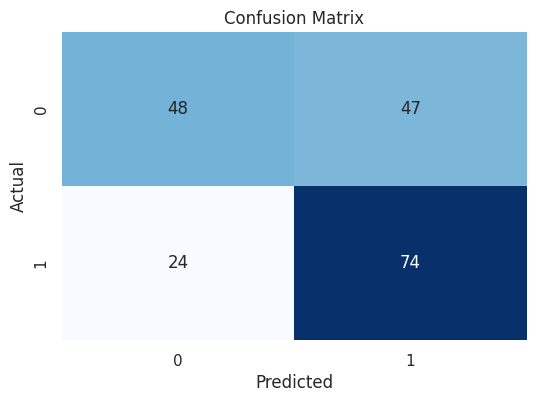

Accucracy All : [0.5326087  0.47321429 0.53571429 0.58333333 0.58333333 0.53571429]
Mean: 0.5406530365769496 ---- Std: 0.037203706180575086
Logloss All : [1.84187361 0.80141169 0.75718978 0.66444506 0.69734937 0.7379726 ]
Mean: 0.9167070178020739 ---- Std: 0.41600718256196945


In [22]:
kf = GroupKFold(n_splits=6)

best_model = None
best_score = 0
fold_results = []
accuracy_all = []
logloss_all = []

# Lặp qua từng fold
for fold, (train_index, val_index) in enumerate(kf.split(X_train, y_train, groups = user_train)):
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
    
    id_user = np.array(user_train)
    # Kiểm tra nhóm trong fold
    train_groups = id_user[train_index]
    val_groups = id_user[val_index]
    
    print(f'User of train_fold({fold}) : {np.unique(train_groups)}')
    print(f'User of val_fold({fold}) :{np.unique(val_groups)}\n')    

    knn = KNeighborsClassifier()
    param_grid = {
        'n_neighbors': [3, 5, 7, 9, 11],        # Số lượng láng giềng k
        'weights': ['uniform', 'distance'],     # Trọng số: uniform (các điểm đều quan trọng), distance (trọng số theo khoảng cách)
        'metric': ['euclidean', 'manhattan', 'minkowski']  # Loại khoảng cách: Euclidean, Manhattan hoặc Minkowski
    }
    grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, cv=GroupKFold(n_splits=3), scoring='accuracy', verbose=1)
    grid_search.fit(X_train_fold, y_train_fold, groups = train_groups)
    print(f"Best parameters found: {grid_search.best_params_}\n" )
    
    y_val_pred = grid_search.predict(X_val_fold)
    y_val_pred_prob = grid_search.predict_proba(X_val_fold)

    accuracy = accuracy_score(y_val_fold, y_val_pred)
    conf_matrix = confusion_matrix(y_val_fold, y_val_pred)
    class_report = classification_report(y_val_fold, y_val_pred)
    logloss = log_loss(y_val_fold, y_val_pred_prob)

    fold_results.append({
        "fold": fold,
        "model": knn,
        "accuracy": accuracy,
        "confusion_matrix": conf_matrix,
        "classification_report": class_report
        })
    accuracy_all.append(accuracy)
    logloss_all.append(logloss)

    if accuracy > best_score:
        best_score = accuracy
        best_model = grid_search

# Dự đoán trên tập kiểm tra
y_pred_knn = best_model.predict(X_test)
y_pred_knn_proba = best_model.predict_proba(X_test)

# Đánh giá mô hình trên tập kiểm tra
knn = accuracy_score(y_test, y_pred_knn)
conf_matrix = confusion_matrix(y_test, y_pred_knn)
class_report = classification_report(y_test, y_pred_knn)
logloss_knn = log_loss(y_test, y_pred_knn_proba)

print("Report:" + class_report)
print(f"ACCURACY: {knn}")
print(f"LOGLOSS: {logloss_knn}")


# Xác định các lớp để hiển thị trong ma trận nhầm lẫn
unique_labels = np.unique(np.concatenate((y_test, y_pred_knn)))

plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=unique_labels.tolist(), 
            yticklabels=unique_labels.tolist())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

accuracy_all = np.array(accuracy_all)
logloss_all = np.array(logloss_all)
print(f"Accucracy All : {accuracy_all}\nMean: {accuracy_all.mean()} ---- Std: {accuracy_all.std()}")
print(f"Logloss All : {logloss_all}\nMean: {logloss_all.mean()} ---- Std: {logloss_all.std()}")

# **DecisionTreeClassifier**

User of train_fold(0) : ['1mpau' '2nxs5' '7swyk' '8a1ep' 'b7mrd' 'c24ur' 'e4gay' 'ef5rq' 'f3j25'
 'ibvx8' 'iz2ps' 'rc1in' 'tn4vl' 'wjxci' 'yljm5']
User of val_fold(0) :['5gpsc' 'dkhty' 'hpbxa']

Fitting 3 folds for each of 432 candidates, totalling 1296 fits
Best parameters found: {'criterion': 'entropy', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 10, 'min_samples_split': 2}

User of train_fold(1) : ['1mpau' '2nxs5' '5gpsc' '7swyk' '8a1ep' 'b7mrd' 'c24ur' 'dkhty' 'e4gay'
 'ef5rq' 'f3j25' 'hpbxa' 'ibvx8' 'iz2ps' 'wjxci']
User of val_fold(1) :['rc1in' 'tn4vl' 'yljm5']

Fitting 3 folds for each of 432 candidates, totalling 1296 fits
Best parameters found: {'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 10, 'min_samples_split': 2}

User of train_fold(2) : ['1mpau' '2nxs5' '5gpsc' '7swyk' '8a1ep' 'b7mrd' 'dkhty' 'e4gay' 'f3j25'
 'hpbxa' 'iz2ps' 'rc1in' 'tn4vl' 'wjxci' 'yljm5']
User of val_fold(2) :['c24ur' 'ef5rq' 'ibvx8']

Fitting 3 

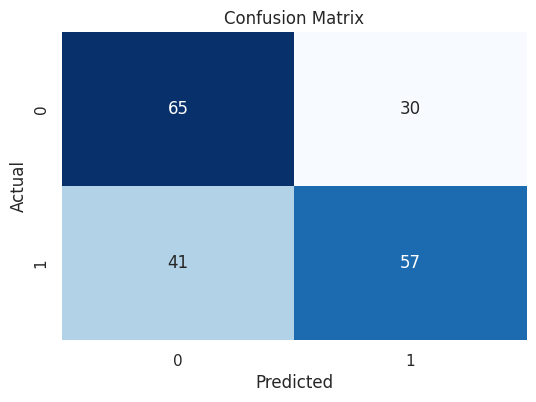

Accucracy All : [0.58695652 0.51785714 0.51785714 0.47222222 0.59375    0.5625    ]
Mean: 0.5418571716126065 ---- Std: 0.04311606877726909
Logloss All : [3.68656733 4.48112996 8.82235658 7.22734982 6.06411348 5.64229165]
Mean: 5.987301471131464 ---- Std: 1.696178031685842


In [23]:
kf = GroupKFold(n_splits=6)

best_model = None
best_score = 0
fold_results = []
accuracy_all = []
logloss_all = []

# Lặp qua từng fold
for fold, (train_index, val_index) in enumerate(kf.split(X_train, y_train, groups = user_train)):
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
    
    id_user = np.array(user_train)
    # Kiểm tra nhóm trong fold
    train_groups = id_user[train_index]
    val_groups = id_user[val_index]
    
    print(f'User of train_fold({fold}) : {np.unique(train_groups)}')
    print(f'User of val_fold({fold}) :{np.unique(val_groups)}\n')    

    cart = DecisionTreeClassifier()
    param_grid = {
        'criterion': ['gini', 'entropy'],   # Chỉ số phân chia: Gini hoặc Entropy
        'max_depth': [None, 10, 20, 30, 40, 50],  # Chiều sâu tối đa của cây
        'min_samples_split': [2, 10, 20],  # Số mẫu tối thiểu để chia nút
        'min_samples_leaf': [1, 5, 10],    # Số mẫu tối thiểu tại mỗi nút lá
        'max_features': [None, 'auto', 'sqrt', 'log2']  # Số lượng đặc trưng được xem xét tại mỗi nút phân chia
    }

    grid_search = GridSearchCV(estimator=cart, param_grid=param_grid, cv=GroupKFold(n_splits=3), scoring='accuracy', verbose=1)
    grid_search.fit(X_train_fold, y_train_fold, groups = train_groups)
    print(f"Best parameters found: {grid_search.best_params_}\n" )
  
    y_val_pred = grid_search.predict(X_val_fold)
    y_val_pred_prob = grid_search.predict_proba(X_val_fold)

    accuracy = accuracy_score(y_val_fold, y_val_pred)
    conf_matrix = confusion_matrix(y_val_fold, y_val_pred)
    class_report = classification_report(y_val_fold, y_val_pred)
    logloss = log_loss(y_val_fold, y_val_pred_prob)

    fold_results.append({
        "fold": fold,
        "model": cart,
        "accuracy": accuracy,
        "confusion_matrix": conf_matrix,
        "classification_report": class_report
        })
    accuracy_all.append(accuracy)
    logloss_all.append(logloss)

    if accuracy > best_score:
        best_score = accuracy
        best_model = grid_search

# Dự đoán trên tập kiểm tra
y_pred_cart = best_model.predict(X_test)
y_pred_cart_proba = best_model.predict_proba(X_test)

# Đánh giá mô hình trên tập kiểm tra
cart = accuracy_score(y_test, y_pred_cart)
conf_matrix = confusion_matrix(y_test, y_pred_cart)
class_report = classification_report(y_test, y_pred_cart)
logloss_cart = log_loss(y_test, y_pred_cart_proba)

print("Report:" + class_report)
print(f"ACCURACY: {cart}")
print(f"LOGLOSS: {logloss_cart}")

# Xác định các lớp để hiển thị trong ma trận nhầm lẫn
unique_labels = np.unique(np.concatenate((y_test, y_pred_cart)))

plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=unique_labels.tolist(), 
            yticklabels=unique_labels.tolist())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

accuracy_all = np.array(accuracy_all)
logloss_all = np.array(logloss_all)
print(f"Accucracy All : {accuracy_all}\nMean: {accuracy_all.mean()} ---- Std: {accuracy_all.std()}")
print(f"Logloss All : {logloss_all}\nMean: {logloss_all.mean()} ---- Std: {logloss_all.std()}")

# **GaussianNB**

User of train_fold(0) : ['1mpau' '2nxs5' '7swyk' '8a1ep' 'b7mrd' 'c24ur' 'e4gay' 'ef5rq' 'f3j25'
 'ibvx8' 'iz2ps' 'rc1in' 'tn4vl' 'wjxci' 'yljm5']
User of val_fold(0) :['5gpsc' 'dkhty' 'hpbxa']

Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best parameters found: {'var_smoothing': 1e-09}

User of train_fold(1) : ['1mpau' '2nxs5' '5gpsc' '7swyk' '8a1ep' 'b7mrd' 'c24ur' 'dkhty' 'e4gay'
 'ef5rq' 'f3j25' 'hpbxa' 'ibvx8' 'iz2ps' 'wjxci']
User of val_fold(1) :['rc1in' 'tn4vl' 'yljm5']

Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best parameters found: {'var_smoothing': 1e-09}

User of train_fold(2) : ['1mpau' '2nxs5' '5gpsc' '7swyk' '8a1ep' 'b7mrd' 'dkhty' 'e4gay' 'f3j25'
 'hpbxa' 'iz2ps' 'rc1in' 'tn4vl' 'wjxci' 'yljm5']
User of val_fold(2) :['c24ur' 'ef5rq' 'ibvx8']

Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best parameters found: {'var_smoothing': 1e-09}

User of train_fold(3) : ['1mpau' '2nxs5' '5gpsc' '7swyk' '8a1ep' 'c24ur' 'dkhty' 'e4gay'

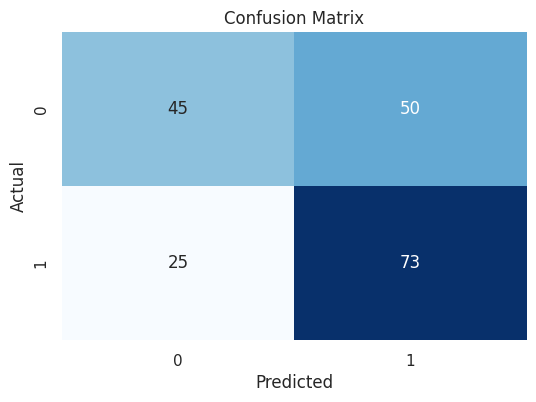

Accucracy All : [0.57608696 0.59821429 0.65178571 0.59259259 0.63541667 0.58035714]
Mean: 0.6057422264396902 ---- Std: 0.028148402678449185
Logloss All : [1.01962924 1.63984998 0.87472833 1.23049648 1.95508026 1.3661002 ]
Mean: 1.3476474146428254 ---- Std: 0.36507310443459495


In [24]:
kf = GroupKFold(n_splits=6)

best_model = None
best_score = 0
fold_results = []
accuracy_all = []
logloss_all = []

# Lặp qua từng fold
for fold, (train_index, val_index) in enumerate(kf.split(X_train, y_train, groups = user_train)):
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
    
    id_user = np.array(user_train)
    # Kiểm tra nhóm trong fold
    train_groups = id_user[train_index]
    val_groups = id_user[val_index]
    
    print(f'User of train_fold({fold}) : {np.unique(train_groups)}')
    print(f'User of val_fold({fold}) :{np.unique(val_groups)}\n')    

    nb = GaussianNB()
    param_grid = {
        'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]  # Điều chỉnh biến nhỏ để tăng độ ổn định tính toán
    }

    grid_search = GridSearchCV(estimator=nb, param_grid=param_grid, cv=GroupKFold(n_splits=3), scoring='accuracy', verbose=1)
    grid_search.fit(X_train_fold, y_train_fold, groups = train_groups)
    print(f"Best parameters found: {grid_search.best_params_}\n" )
  
    y_val_pred = grid_search.predict(X_val_fold)
    y_val_pred_proba = grid_search.predict_proba(X_val_fold)

    accuracy = accuracy_score(y_val_fold, y_val_pred)
    conf_matrix = confusion_matrix(y_val_fold, y_val_pred)
    class_report = classification_report(y_val_fold, y_val_pred)
    logloss = log_loss(y_val_fold, y_val_pred_proba)

    fold_results.append({
        "fold": fold,
        "model": nb,
        "accuracy": accuracy,
        "confusion_matrix": conf_matrix,
        "classification_report": class_report
        })
    accuracy_all.append(accuracy)
    logloss_all.append(logloss)

    if accuracy > best_score:
        best_score = accuracy
        best_model = grid_search

# Dự đoán trên tập kiểm tra
y_pred_gnb = best_model.predict(X_test)
y_pred_gnb_proba = best_model.predict_proba(X_test)

# Đánh giá mô hình trên tập kiểm tra
gnb = accuracy_score(y_test, y_pred_gnb)
conf_matrix = confusion_matrix(y_test, y_pred_gnb)
class_report = classification_report(y_test, y_pred_gnb)
logloss_gnb = log_loss(y_test, y_pred_gnb_proba)

print("Report:" + class_report)
print(f"ACCURACY: {gnb}")
print(f"LOGLOSS: {logloss_gnb}")

# Xác định các lớp để hiển thị trong ma trận nhầm lẫn
unique_labels = np.unique(np.concatenate((y_test, y_pred_gnb)))

plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=unique_labels.tolist(), 
            yticklabels=unique_labels.tolist())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

accuracy_all = np.array(accuracy_all)
logloss_all = np.array(logloss_all)
print(f"Accucracy All : {accuracy_all}\nMean: {accuracy_all.mean()} ---- Std: {accuracy_all.std()}")
print(f"Logloss All : {logloss_all}\nMean: {logloss_all.mean()} ---- Std: {logloss_all.std()}")

# **AdaBoots**

User of train_fold(0) : ['1mpau' '2nxs5' '7swyk' '8a1ep' 'b7mrd' 'c24ur' 'e4gay' 'ef5rq' 'f3j25'
 'ibvx8' 'iz2ps' 'rc1in' 'tn4vl' 'wjxci' 'yljm5']
User of val_fold(0) :['5gpsc' 'dkhty' 'hpbxa']

Fitting 3 folds for each of 9 candidates, totalling 27 fits
Best parameters found: {'learning_rate': 0.1, 'n_estimators': 50}

User of train_fold(1) : ['1mpau' '2nxs5' '5gpsc' '7swyk' '8a1ep' 'b7mrd' 'c24ur' 'dkhty' 'e4gay'
 'ef5rq' 'f3j25' 'hpbxa' 'ibvx8' 'iz2ps' 'wjxci']
User of val_fold(1) :['rc1in' 'tn4vl' 'yljm5']

Fitting 3 folds for each of 9 candidates, totalling 27 fits
Best parameters found: {'learning_rate': 0.01, 'n_estimators': 200}

User of train_fold(2) : ['1mpau' '2nxs5' '5gpsc' '7swyk' '8a1ep' 'b7mrd' 'dkhty' 'e4gay' 'f3j25'
 'hpbxa' 'iz2ps' 'rc1in' 'tn4vl' 'wjxci' 'yljm5']
User of val_fold(2) :['c24ur' 'ef5rq' 'ibvx8']

Fitting 3 folds for each of 9 candidates, totalling 27 fits
Best parameters found: {'learning_rate': 0.1, 'n_estimators': 100}

User of train_fold(3) : ['1mpau

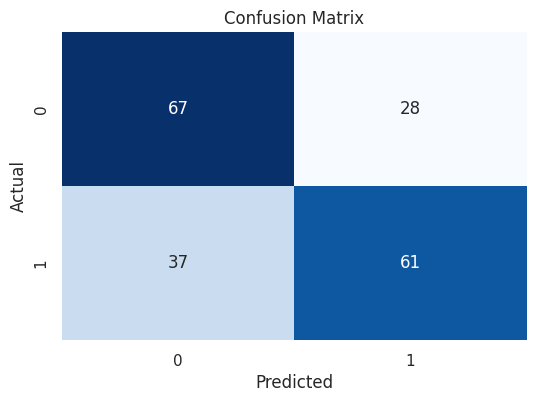

Accucracy All : [0.4673913  0.69642857 0.67857143 0.55555556 0.63541667 0.58928571]
Mean: 0.6037748734759604 ---- Std: 0.07779883435035564
Logloss All : [0.68486529 0.66989461 0.6815539  0.67981665 0.68493732 0.67116512]
Mean: 0.6787054806272845 ---- Std: 0.006063767794035921


In [25]:
kf = GroupKFold(n_splits=6)

best_model = None
best_score = 0
fold_results = []
accuracy_all = []
logloss_all = []

# Lặp qua từng fold
for fold, (train_index, val_index) in enumerate(kf.split(X_train, y_train, groups = user_train)):
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
    
    id_user = np.array(user_train)
    # Kiểm tra nhóm trong fold
    train_groups = id_user[train_index]
    val_groups = id_user[val_index]
    
    print(f'User of train_fold({fold}) : {np.unique(train_groups)}')
    print(f'User of val_fold({fold}) :{np.unique(val_groups)}\n')    

    adaboost = AdaBoostClassifier()
    param_grid = {
        'n_estimators': [50, 100, 200],  # Số lượng bộ phân loại cơ sở (number of weak learners)
        'learning_rate': [0.01, 0.1, 1.0],  # Tốc độ học (learning rate)
    }

    grid_search = GridSearchCV(estimator=adaboost, param_grid=param_grid, cv=GroupKFold(n_splits=3), scoring='accuracy', verbose=1)
    grid_search.fit(X_train_fold, y_train_fold, groups = train_groups)
    print(f"Best parameters found: {grid_search.best_params_}\n" )
   
    y_val_pred = grid_search.predict(X_val_fold)
    y_val_pred_proba = grid_search.predict_proba(X_val_fold)

    accuracy = accuracy_score(y_val_fold, y_val_pred)
    conf_matrix = confusion_matrix(y_val_fold, y_val_pred)
    class_report = classification_report(y_val_fold, y_val_pred)
    logloss = log_loss(y_val_fold, y_val_pred_proba)

    fold_results.append({
        "fold": fold,
        "model": adaboost,
        "accuracy": accuracy,
        "confusion_matrix": conf_matrix,
        "classification_report": class_report
        })
    accuracy_all.append(accuracy)
    logloss_all.append(logloss)

    if accuracy > best_score:
        best_score = accuracy
        best_model = grid_search

# Dự đoán trên tập kiểm tra
y_pred_ab = best_model.predict(X_test)
y_pred_ab_proba = best_model.predict_proba(X_test)

# Đánh giá mô hình trên tập kiểm tra
ab = accuracy_score(y_test, y_pred_ab)
conf_matrix = confusion_matrix(y_test, y_pred_ab)
class_report = classification_report(y_test, y_pred_ab)
logloss_ab = log_loss(y_test, y_pred_ab_proba)

print("Report:" + class_report)
print(f"ACCURACY: {ab}")
print(f"LOGLOSS: {logloss_ab}")

# Xác định các lớp để hiển thị trong ma trận nhầm lẫn
unique_labels = np.unique(np.concatenate((y_test, y_pred_ab)))

plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=unique_labels.tolist(), 
            yticklabels=unique_labels.tolist())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

accuracy_all = np.array(accuracy_all)
logloss_all = np.array(logloss_all)
print(f"Accucracy All : {accuracy_all}\nMean: {accuracy_all.mean()} ---- Std: {accuracy_all.std()}")
print(f"Logloss All : {logloss_all}\nMean: {logloss_all.mean()} ---- Std: {logloss_all.std()}")

# **RandomForestClassifier**

User of train_fold(0) : ['1mpau' '2nxs5' '7swyk' '8a1ep' 'b7mrd' 'c24ur' 'e4gay' 'ef5rq' 'f3j25'
 'ibvx8' 'iz2ps' 'rc1in' 'tn4vl' 'wjxci' 'yljm5']
User of val_fold(0) :['5gpsc' 'dkhty' 'hpbxa']

Fitting 3 folds for each of 81 candidates, totalling 243 fits
Best parameters found: {'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}

User of train_fold(1) : ['1mpau' '2nxs5' '5gpsc' '7swyk' '8a1ep' 'b7mrd' 'c24ur' 'dkhty' 'e4gay'
 'ef5rq' 'f3j25' 'hpbxa' 'ibvx8' 'iz2ps' 'wjxci']
User of val_fold(1) :['rc1in' 'tn4vl' 'yljm5']

Fitting 3 folds for each of 81 candidates, totalling 243 fits
Best parameters found: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}

User of train_fold(2) : ['1mpau' '2nxs5' '5gpsc' '7swyk' '8a1ep' 'b7mrd' 'dkhty' 'e4gay' 'f3j25'
 'hpbxa' 'iz2ps' 'rc1in' 'tn4vl' 'wjxci' 'yljm5']
User of val_fold(2) :['c24ur' 'ef5rq' 'ibvx8']

Fitting 3 folds for each of 81 candidates, totalling 243 fits
Best par

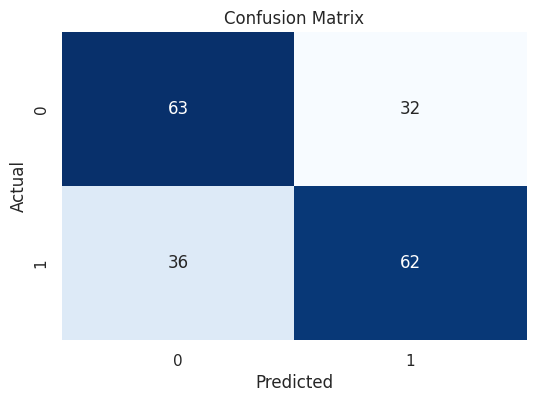

Accucracy All : [0.5326087  0.58928571 0.65178571 0.57407407 0.65625    0.5625    ]
Mean: 0.5944173663829461 ---- Std: 0.0454489005562902
Logloss All : [0.68329562 0.67910206 0.63740363 0.67438852 0.62160144 0.71525569]
Mean: 0.6685078267405112 ---- Std: 0.030872162705975027


In [26]:
kf = GroupKFold(n_splits=6)

best_model = None
best_score = 0
fold_results = []
accuracy_all = []
logloss_all = []

# Lặp qua từng fold
for fold, (train_index, val_index) in enumerate(kf.split(X_train, y_train, groups = user_train)):
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
    
    id_user = np.array(user_train)
    # Kiểm tra nhóm trong fold
    train_groups = id_user[train_index]
    val_groups = id_user[val_index]
    
    print(f'User of train_fold({fold}) : {np.unique(train_groups)}')
    print(f'User of val_fold({fold}) :{np.unique(val_groups)}\n')    

    rf = RandomForestClassifier()
    param_grid = {
        'n_estimators': [100, 200, 300],  # Number of trees in the forest
        'max_depth': [10, 20, 30],        # Maximum depth of the tree
        'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split a node
        'min_samples_leaf': [1, 2, 4]     # Minimum number of samples required at each leaf node
    }

    grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=GroupKFold(n_splits=3), scoring='accuracy', verbose=1)
    grid_search.fit(X_train_fold, y_train_fold, groups = train_groups)
    print(f"Best parameters found: {grid_search.best_params_}\n" )
    
    y_val_pred = grid_search.predict(X_val_fold)
    y_val_pred_proba = grid_search.predict_proba(X_val_fold)

    accuracy = accuracy_score(y_val_fold, y_val_pred)
    conf_matrix = confusion_matrix(y_val_fold, y_val_pred)
    class_report = classification_report(y_val_fold, y_val_pred)
    logloss_fold_rf = log_loss(y_val_fold, y_val_pred_proba)

    fold_results.append({
        "fold": fold,
        "model": rf,
        "accuracy": accuracy,
        "confusion_matrix": conf_matrix,
        "classification_report": class_report
        })
    accuracy_all.append(accuracy)
    logloss_all.append(logloss_fold_rf)

    if accuracy > best_score:
        best_score = accuracy
        best_model = grid_search

# Dự đoán trên tập kiểm tra
y_pred_rf = best_model.predict(X_test)
y_pred_rf_proba = best_model.predict_proba(X_test)

# Đánh giá mô hình trên tập kiểm tra
rf = accuracy_score(y_test, y_pred_rf)
conf_matrix = confusion_matrix(y_test, y_pred_rf)
class_report = classification_report(y_test, y_pred_rf)
logloss_rf = log_loss(y_test, y_pred_rf_proba)

print("Report:" + class_report)
print(f"ACCURACY: {rf}")
print(f"LOGLOSS: {logloss_rf}")

# Xác định các lớp để hiển thị trong ma trận nhầm lẫn
unique_labels = np.unique(np.concatenate((y_test, y_pred_rf)))

plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=unique_labels.tolist(), 
            yticklabels=unique_labels.tolist())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

accuracy_all = np.array(accuracy_all)
logloss_all = np.array(logloss_all)
print(f"Accucracy All : {accuracy_all}\nMean: {accuracy_all.mean()} ---- Std: {accuracy_all.std()}")
print(f"Logloss All : {logloss_all}\nMean: {logloss_all.mean()} ---- Std: {logloss_all.std()}")

# GradientBoostingClassifier

In [28]:
kf = GroupKFold(n_splits=6)

best_model = None
best_score = 0
fold_results = []
accuracy_all = []
logloss_all = []

# Lặp qua từng fold
for fold, (train_index, val_index) in enumerate(kf.split(X_train, y_train, groups = user_train)):
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
    
    id_user = np.array(user_train)
    # Kiểm tra nhóm trong fold
    train_groups = id_user[train_index]
    val_groups = id_user[val_index]

    print(f'User of train_fold({fold}) : {np.unique(train_groups)}')
    print(f'User of val_fold({fold}) :{np.unique(val_groups)}\n')    

    gbm = GradientBoostingClassifier()
    param_grid = {
        'n_estimators': [100, 200, 300],  # Number of boosting stages to be run
        'learning_rate': [0.01, 0.1, 0.2],  # Step size shrinkage
        'max_depth': [3, 5, 7],          # Maximum depth of the tree
        'min_samples_split': [2, 5, 10], # Minimum number of samples required to split a node
        'min_samples_leaf': [1, 2, 4]    # Minimum number of samples required at each leaf node
    }

    grid_search = GridSearchCV(estimator=gbm, param_grid=param_grid, cv=GroupKFold(n_splits=3), scoring='accuracy', verbose=1)
    grid_search.fit(X_train_fold, y_train_fold, groups = train_groups)
    print(f"Best parameters found: {grid_search.best_params_}\n" )
    
    y_val_pred = grid_search.predict(X_val_fold)
    y_val_pred_proba = grid_search.predict_proba(X_val_fold)

    accuracy = accuracy_score(y_val_fold, y_val_pred)
    conf_matrix = confusion_matrix(y_val_fold, y_val_pred)
    class_report = classification_report(y_val_fold, y_val_pred)
    logloss_fold_gb = log_loss(y_val_fold, y_val_pred_proba)

    fold_results.append({
        "fold": fold,
        "model": gbm,
        "accuracy": accuracy,
        "confusion_matrix": conf_matrix,
        "classification_report": class_report
        })
    accuracy_all.append(accuracy)
    logloss_all.append(logloss_fold_gb)

    if accuracy > best_score:
        best_score = accuracy
        best_model = grid_search

# Dự đoán trên tập kiểm tra
y_pred_gb = best_model.predict(X_test)
y_pred_gb_proba = best_model.predict_proba(X_test)

# Đánh giá mô hình trên tập kiểm tra
gb = accuracy_score(y_test, y_pred_gb)
conf_matrix = confusion_matrix(y_test, y_pred_gb)
class_report = classification_report(y_test, y_pred_gb)
logloss_gb = log_loss(y_test, y_pred_gb_proba)

print("Report:" + class_report)
print(f"ACCURACY: {gb}")
print(f"LOGLOSS: {logloss_gb}")

# Xác định các lớp để hiển thị trong ma trận nhầm lẫn
unique_labels = np.unique(np.concatenate((y_test, y_pred_gb)))

plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=unique_labels.tolist(), 
            yticklabels=unique_labels.tolist())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

accuracy_all = np.array(accuracy_all)
logloss_all = np.array(accuracy_all)
print(f"Accucracy All : {accuracy_all}\nMean: {accuracy_all.mean()} ---- Std: {accuracy_all.std()}")
print(f"Logloss All : {logloss_all}\nMean: {logloss_all.mean()} ---- Std: {logloss_all.std()}")

User of train_fold(0) : ['1mpau' '2nxs5' '7swyk' '8a1ep' 'b7mrd' 'c24ur' 'e4gay' 'ef5rq' 'f3j25'
 'ibvx8' 'iz2ps' 'rc1in' 'tn4vl' 'wjxci' 'yljm5']
User of val_fold(0) :['5gpsc' 'dkhty' 'hpbxa']

Fitting 3 folds for each of 243 candidates, totalling 729 fits
Best parameters found: {'learning_rate': 0.01, 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}

User of train_fold(1) : ['1mpau' '2nxs5' '5gpsc' '7swyk' '8a1ep' 'b7mrd' 'c24ur' 'dkhty' 'e4gay'
 'ef5rq' 'f3j25' 'hpbxa' 'ibvx8' 'iz2ps' 'wjxci']
User of val_fold(1) :['rc1in' 'tn4vl' 'yljm5']

Fitting 3 folds for each of 243 candidates, totalling 729 fits
Best parameters found: {'learning_rate': 0.01, 'max_depth': 3, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}

User of train_fold(2) : ['1mpau' '2nxs5' '5gpsc' '7swyk' '8a1ep' 'b7mrd' 'dkhty' 'e4gay' 'f3j25'
 'hpbxa' 'iz2ps' 'rc1in' 'tn4vl' 'wjxci' 'yljm5']
User of val_fold(2) :['c24ur' 'ef5rq' 'ibvx8']

Fitting 3 folds for each 

KeyboardInterrupt: 

# SVM

In [ ]:
kf = GroupKFold(n_splits=6)

best_model = None
best_score = 0
fold_results = []
accuracy_all = []
logloss_all = []

# Lặp qua từng fold
for fold, (train_index, val_index) in enumerate(kf.split(X_train, y_train, groups = user_train)):
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
    
    id_user = np.array(user_train)
    # Kiểm tra nhóm trong fold
    train_groups = id_user[train_index]
    val_groups = id_user[val_index]
    
    print(f'User of train_fold({fold}) : {np.unique(train_groups)}')
    print(f'User of val_fold({fold}) :{np.unique(val_groups)}\n')    

    svm = SVC(probability=True)
    param_grid = {
        'C': [0.1, 1, 10, 100],                # Điều chỉnh độ phạt sai số
        'kernel': ['linear', 'rbf', 'poly'],    # Các loại kernel
        'gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1],  # Tham số gamma cho RBF, poly kernels
        'degree': [2, 3, 4]                    # Bậc của polynomial kernel (nếu dùng 'poly')
    }

    grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, cv=GroupKFold(n_splits=3), scoring='accuracy', verbose=1)
    grid_search.fit(X_train_fold, y_train_fold, groups = train_groups)
    print(f"Best parameters found: {grid_search.best_params_}\n" )
  
    y_val_pred = grid_search.predict(X_val_fold)   
    y_val_pred_proba = grid_search.predict(X_val_fold)

    accuracy = accuracy_score(y_val_fold, y_val_pred)
    conf_matrix = confusion_matrix(y_val_fold, y_val_pred)
    class_report = classification_report(y_val_fold, y_val_pred)
    logloss_fold_svm = log_loss(y_val_fold, y_val_pred_proba)

    fold_results.append({
        "fold": fold,
        "model": gbm,
        "accuracy": accuracy,
        "confusion_matrix": conf_matrix,
        "classification_report": class_report
        })
    accuracy_all.append(accuracy)
    logloss_all.append(logloss_fold_svm)
    
    if accuracy > best_score:
        best_score = accuracy
        best_model = grid_search

# Dự đoán trên tập kiểm tra
y_pred_svm = best_model.predict(X_test)
y_pred_svm_proba = best_model.predict_proba(X_test)

# Đánh giá mô hình trên tập kiểm tra
svm = accuracy_score(y_test, y_pred_svm)
conf_matrix = confusion_matrix(y_test, y_pred_svm)
class_report = classification_report(y_test, y_pred_svm)
logloss_svm = log_loss(y_test, y_pred_svm_proba)

print("Report:" + class_report)
print(f"ACCURACY: {svm}")
print(f"LOGLOSS: {logloss_svm}")

# Xác định các lớp để hiển thị trong ma trận nhầm lẫn
unique_labels = np.unique(np.concatenate((y_test, y_pred_svm)))

plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=unique_labels.tolist(), 
            yticklabels=unique_labels.tolist())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

accuracy_all = np.array(accuracy_all)
logloss_all = np.array(accuracy_all)
print(f"Accucracy All : {accuracy_all}\nMean: {accuracy_all.mean()} ---- Std: {accuracy_all.std()}")
print(f"Logloss All : {logloss_all}\nMean: {logloss_all.mean()} ---- Std: {logloss_all.std()}")

In [ ]:
data = {
    'Model': ['LR', 'LDA', 'KNN', 'CART', 'GNB', 'RF', 'AB','GB','SVM'],
    'Accuracy': [lr, lda, knn, cart, gnb, rf, ab, gb, svm]
}

# Tạo DataFrame từ dữ liệu
df = pd.DataFrame(data)

# Chuyển đổi cột 'Accuracy' thành kiểu số thực
df['Accuracy'] = df['Accuracy'].astype(float)

# Vẽ biểu đồ barplot
plt.figure(figsize=(10, 6))
barplot = sns.barplot(x='Model', y='Accuracy', data=df, palette='viridis')
plt.title('Algorithm Comparison')
plt.ylabel('Accuracy (Test)')
plt.ylim(0, 1)  # Đặt giới hạn trục y từ 0 đến 1

# Thêm thông số trên các cột
for p in barplot.patches:
    barplot.annotate(f'{p.get_height():.2f}', 
                     (p.get_x() + p.get_width() / 2., p.get_height()), 
                     ha='center', va='bottom', 
                     fontsize=12)

plt.show()


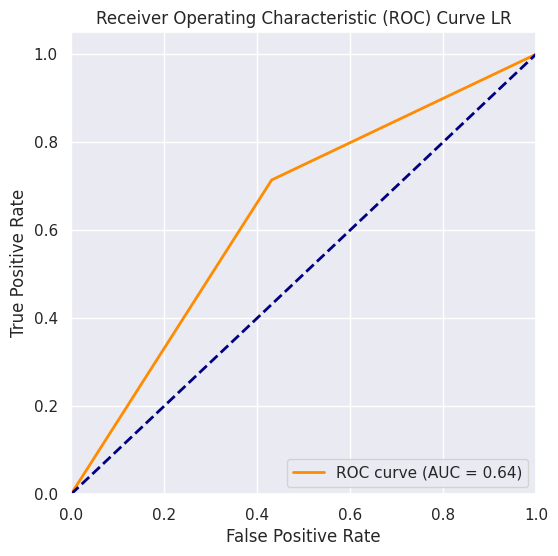

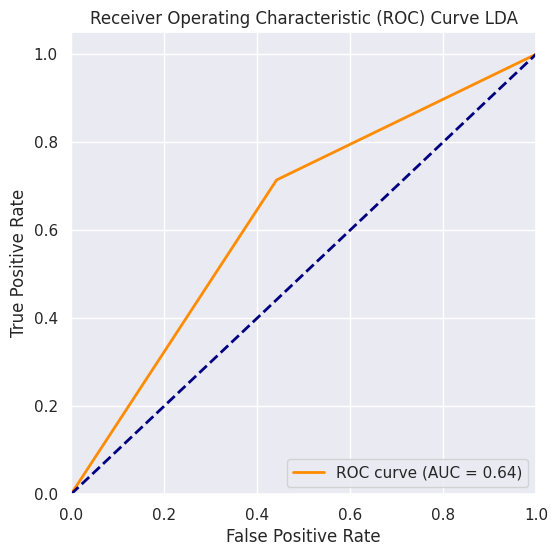

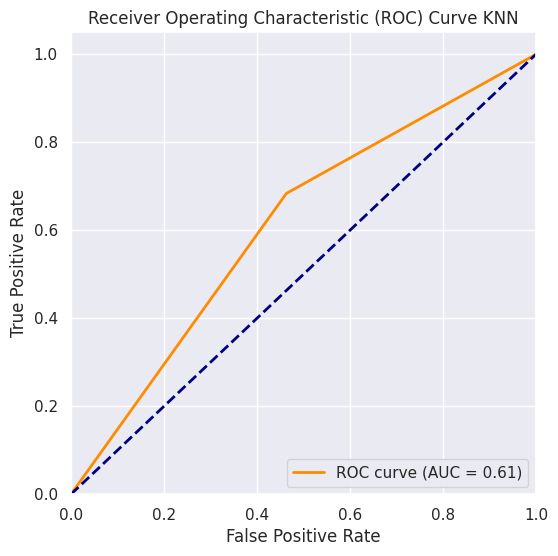

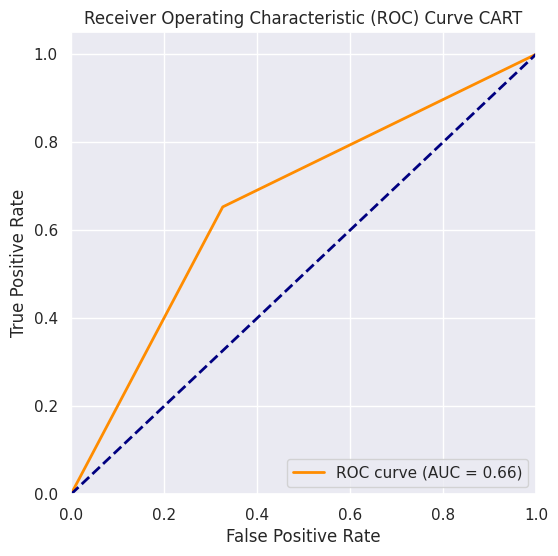

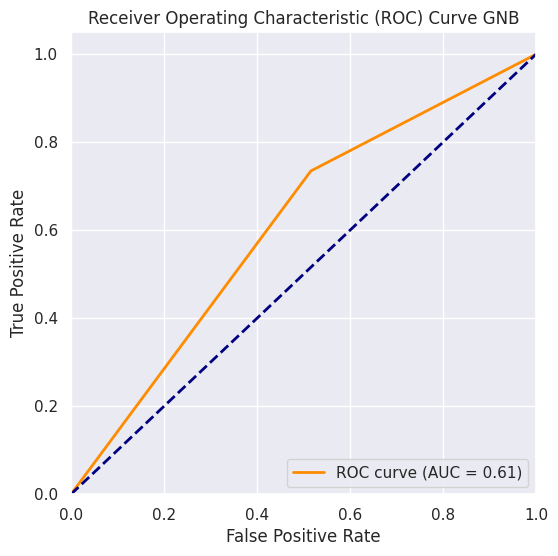

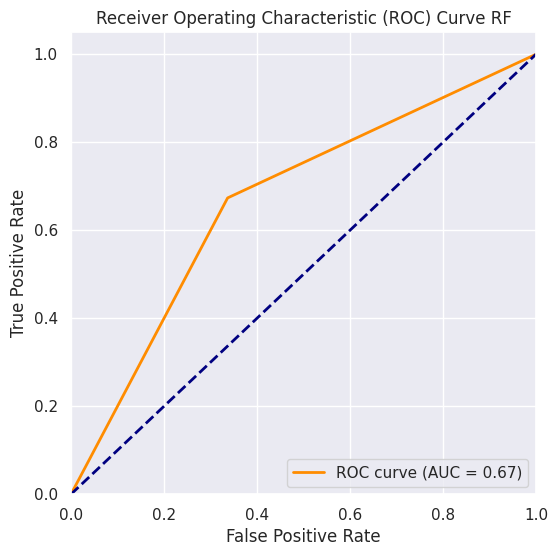

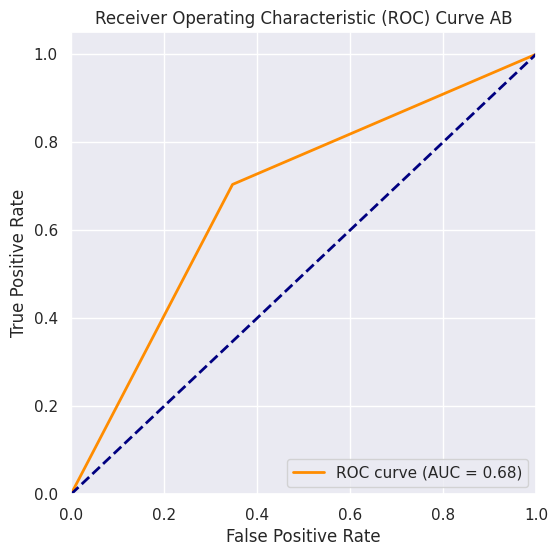

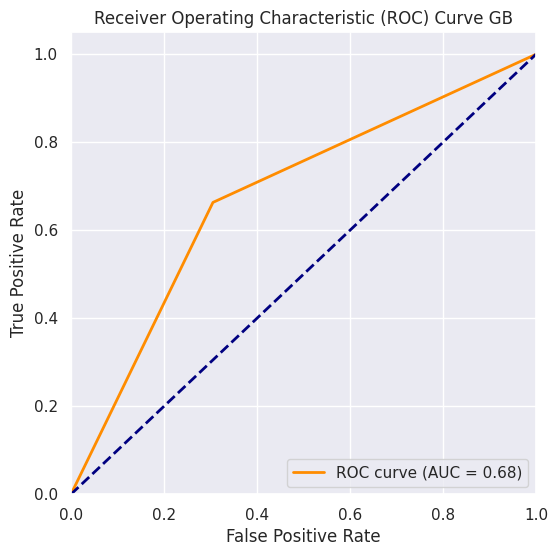

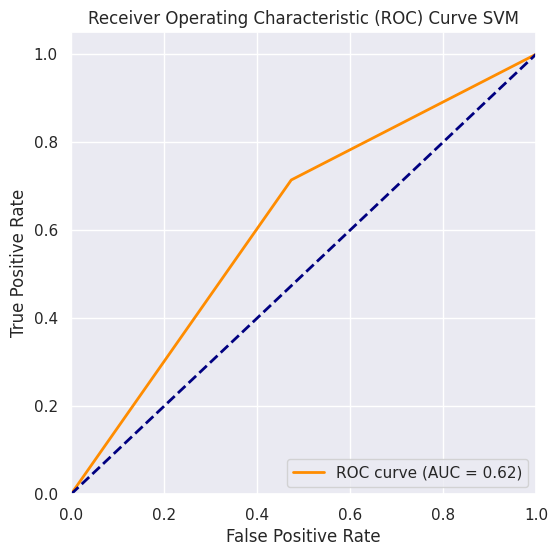

In [25]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt

y = [y_pred_lr, y_pred_lda, y_pred_knn, y_pred_cart, y_pred_gnb, y_pred_rf, y_pred_ab, y_pred_gb, y_pred_svm]
Model = ['LR', 'LDA', 'KNN', 'CART', 'GNB', 'RF', 'AB', 'GB', 'SVM']

# Khởi tạo figure
plt.figure(figsize=(8, 8))

# Tính toán đường cong ROC và AUC cho mỗi mô hình và vẽ vào cùng một biểu đồ
for i, y_pred in enumerate(y):
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)

    # Vẽ đường cong ROC cho từng mô hình
    plt.plot(fpr, tpr, lw=2, label=f'{Model[i]} (AUC = {roc_auc:.2f})')

# Đường chéo tham chiếu với AUC = 0.5
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

# Thiết lập giới hạn của trục
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

# Thêm tiêu đề và nhãn trục
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')

# Thêm chú thích (legend) để phân biệt các mô hình
plt.legend(loc="lower right")

# Hiển thị biểu đồ
plt.show()

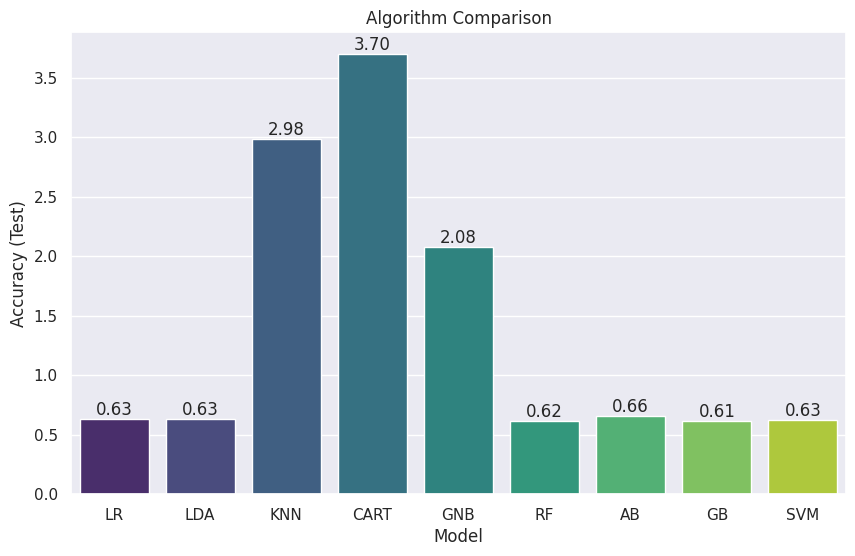

In [30]:
data = {
    'Model': ['LR', 'LDA', 'KNN', 'CART', 'GNB', 'RF', 'AB','GB','SVM'],
    'Logloss': [lr_logloss, logloss_lda, logloss_knn, logloss_cart, logloss_gnb, logloss_rf, logloss_ab, logloss_gb, logloss_svm]
}

# Tạo DataFrame từ dữ liệu
df = pd.DataFrame(data)

# Chuyển đổi cột 'Accuracy' thành kiểu số thực
df['Logloss'] = df['Logloss'].astype(float)

# Vẽ biểu đồ barplot
plt.figure(figsize=(10, 6))
barplot = sns.barplot(x='Model', y='Logloss', data=df, palette='viridis')
plt.title('Algorithm Comparison')
plt.ylabel('Accuracy (Test)')

# Thêm thông số trên các cột
for p in barplot.patches:
    barplot.annotate(f'{p.get_height():.2f}', 
                     (p.get_x() + p.get_width() / 2., p.get_height()), 
                     ha='center', va='bottom', 
                     fontsize=12)

plt.show()
